In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from xml.dom import minidom

import umap
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_extraction.text import TfidfTransformer

import torch
import torch.nn.functional as F
from contrastive_loss_pytorch import ContrastiveLoss

from sklearn.metrics import mean_absolute_error
from scipy import stats
from scipy.spatial.distance import cdist
import pickle
import tqdm

/home/ms275088/ms275088/Athaya/AthayaPaperCodes/pythonEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Test data for model testing

In [2]:
cancer_mrna_tr = np.load('./gc_data/gc_cancer_mrna_tr.npy')
hc_mrna_tr = np.load('./gc_data/gc_hc_mrna_tr.npy')

cancer_mrna_ts = np.load('./gc_data/gc_cancer_mrna_ts.npy')
hc_mrna_ts = np.load('./gc_data/gc_hc_mrna_ts.npy')

cancer_exrna_tr = np.load('./gc_data/gc_cancer_exrna_tr.npy')
hc_exrna_tr = np.load('./gc_data/gc_hc_exrna_tr.npy')

cancer_exrna_ts = np.load('./gc_data/gc_cancer_exrna_ts.npy')
hc_exrna_ts = np.load('./gc_data/gc_hc_exrna_ts.npy')

## Baseline model (exRNA to mRNA)

In [3]:
# Creating a PyTorch class
class AE(torch.nn.Module):
	def __init__(self,input_dim=cancer_exrna_ts.shape[1], output_dim=cancer_mrna_ts.shape[1]):
		super().__init__()
		# Building a linear encoder with Linear
		# layer followed by Relu activation function
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(input_dim, 512),
			torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
			torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
		)
		
		# Building an linear decoder with Linear
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
			torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
			torch.nn.Linear(512, output_dim),
			torch.nn.Sigmoid()
		)
	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [4]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


In [5]:
checkpoint = torch.load('./models/gc_compare_extom.pt',map_location=torch.device('cpu'))
model = AE(input_dim=cancer_exrna_ts.shape[1], output_dim=cancer_mrna_ts.shape[1])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


AE(
  (encoder): Sequential(
    (0): Linear(in_features=2539, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=36, bias=True)
    (9): ReLU()
    (10): Linear(in_features=36, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=1653, bias=True)
    (11): Sigmoid()
  )
)

In [6]:
##4. Integration visualization - test
model.eval()
with torch.no_grad():
    model.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    cex_encoder_ts = model.encoder(X_all_tensor_cex_ts)
    cm_decoder = model.decoder(cex_encoder_ts)
    b_pred_cm_ts = torch.Tensor.cpu(cm_decoder).detach().numpy()

    hex_encoder_ts = model.encoder(X_all_tensor_hex_ts)
    hm_decoder = model.decoder(hex_encoder_ts)
    b_pred_hm_ts = torch.Tensor.cpu(hm_decoder).detach().numpy()


In [8]:
# Unpaired metric
print("\n\n########## Baseline model (exRNA to mRNA) ##########\n")

print(stats.pearsonr(np.mean(b_pred_cm_ts,axis=0),np.mean(cancer_mrna_ts,axis=0)))
print(stats.pearsonr(np.mean(b_pred_hm_ts,axis=0),np.mean(hc_mrna_ts,axis=0)))
print(stats.pearsonr(np.mean(np.concatenate([b_pred_cm_ts,b_pred_hm_ts]),axis=0),
                     np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))

#Unpaired Spearman
print(stats.spearmanr(np.mean(b_pred_cm_ts,axis=0),np.mean(cancer_mrna_ts,axis=0)))
print(stats.spearmanr(np.mean(b_pred_hm_ts,axis=0),np.mean(hc_mrna_ts,axis=0)))
print(stats.spearmanr(np.mean(np.concatenate([b_pred_cm_ts,b_pred_hm_ts]),axis=0),
                     np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))

#Unpaired MAE
from sklearn.metrics import mean_absolute_error

pred_extom = np.concatenate([b_pred_cm_ts,b_pred_hm_ts])
true_extom = np.concatenate([cancer_mrna_ts,hc_mrna_ts])

print("MAE Cancer mRNA: ",mean_absolute_error(np.mean(b_pred_cm_ts,axis=0), np.mean(cancer_mrna_ts,axis=0)))
print("MAE Healthy mRNA: ",mean_absolute_error(np.mean(b_pred_hm_ts,axis=0),np.mean(hc_mrna_ts,axis=0)))
print("MAE mRNA: ",mean_absolute_error(np.mean(pred_extom,axis=0),
                     np.mean(true_extom,axis=0)))

print("\n\n\n")



########## Baseline model (exRNA to mRNA) ##########

PearsonRResult(statistic=0.3188855164541756, pvalue=2.194020592179969e-40)
PearsonRResult(statistic=0.2372918848154853, pvalue=1.3678070091564919e-22)
PearsonRResult(statistic=0.279453284574605, pvalue=4.925067787878062e-31)
SignificanceResult(statistic=0.9422809052848439, pvalue=0.0)
SignificanceResult(statistic=0.991141843183657, pvalue=0.0)
SignificanceResult(statistic=0.9961980976276785, pvalue=0.0)
MAE Cancer mRNA:  2.1832826926027122
MAE Healthy mRNA:  5.961526775364571
MAE mRNA:  3.7585098217876505






## Baseline Model (mRNA to exRNA)

In [9]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE_mtoex(torch.nn.Module):
	def __init__(self,input_dim=cancer_mrna_ts.shape[1], output_dim=cancer_exrna_ts.shape[1]):
		super().__init__()
		# Building a linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(input_dim, 512),
			torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
			torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
# 			torch.nn.ReLU(),
# 			torch.nn.Linear(18, 9)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
# 			torch.nn.Linear(9, 18),
# 			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
			torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
			torch.nn.Linear(512, output_dim),
			torch.nn.Sigmoid()
		)
	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [10]:
# Model Initialization
model_mtoex = AE_mtoex()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model_mtoex.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


In [11]:
checkpoint = torch.load('./models/gc_compare_mtoex.pt',map_location=torch.device('cpu'))
model_mtoex = AE_mtoex(input_dim=cancer_mrna_ts.shape[1], output_dim=cancer_exrna_ts.shape[1])
model_mtoex.load_state_dict(checkpoint['model_state_dict'])
model_mtoex.eval()


AE_mtoex(
  (encoder): Sequential(
    (0): Linear(in_features=1653, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=36, bias=True)
    (9): ReLU()
    (10): Linear(in_features=36, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=2539, bias=True)
    (11): Sigmoid()
  )
)

In [12]:
##4. Integration visualization - test
model_mtoex.eval()
with torch.no_grad():
    model_mtoex.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    cm_encoder_ts = model_mtoex.encoder(X_all_tensor_cm_ts)
    cex_decoder = model_mtoex.decoder(cm_encoder_ts)
    b_pred_cex_ts = torch.Tensor.cpu(cex_decoder).detach().numpy()

    hm_encoder_ts = model_mtoex.encoder(X_all_tensor_hm_ts)
    hex_decoder = model_mtoex.decoder(hm_encoder_ts)
    b_pred_hex_ts = torch.Tensor.cpu(hex_decoder).detach().numpy()

In [13]:
#Unpaired Pearsonr
print("\n\n########## Baseline Model (mRNA to exRNA) ##########\n")
print(stats.pearsonr(np.mean(b_pred_cex_ts,axis=0),np.mean(cancer_exrna_ts,axis=0)))
print(stats.pearsonr(np.mean(b_pred_hex_ts,axis=0),np.mean(hc_exrna_ts,axis=0)))
print(stats.pearsonr(np.mean(np.concatenate([b_pred_cex_ts,b_pred_hex_ts]),axis=0),
                     np.mean(np.concatenate([cancer_exrna_ts,hc_exrna_ts]),axis=0)))

#Unpaired Spearman
print(stats.spearmanr(np.mean(b_pred_cex_ts,axis=0),np.mean(cancer_exrna_ts,axis=0)))
print(stats.spearmanr(np.mean(b_pred_hex_ts,axis=0),np.mean(hc_exrna_ts,axis=0)))
print(stats.spearmanr(np.mean(np.concatenate([b_pred_cex_ts,b_pred_hex_ts]),axis=0),
                     np.mean(np.concatenate([cancer_exrna_ts,hc_exrna_ts]),axis=0)))

pred_mtoex = np.concatenate([b_pred_cex_ts,b_pred_hex_ts])
true_mtoex = np.concatenate([cancer_exrna_ts,hc_exrna_ts])

#Unpaired MAE
from sklearn.metrics import mean_absolute_error

print("MAE Cancer exRNA: ",mean_absolute_error(np.mean(b_pred_cex_ts,axis=0), np.mean(cancer_exrna_ts,axis=0)))
print("MAE Healthy exRNA: ",mean_absolute_error(np.mean(b_pred_hex_ts,axis=0),np.mean(hc_exrna_ts,axis=0)))
print("MAE exRNA: ",mean_absolute_error(np.mean(pred_mtoex,axis=0),
                     np.mean(true_mtoex,axis=0)))

print("\n\n\n")



########## Baseline Model (mRNA to exRNA) ##########

PearsonRResult(statistic=0.3924899813726011, pvalue=2.771857369964331e-94)
PearsonRResult(statistic=0.013354232966938214, pvalue=0.5012028981574274)
PearsonRResult(statistic=0.19803985255257267, pvalue=7.202788591227272e-24)
SignificanceResult(statistic=0.5030891790214833, pvalue=5.3946234603047884e-163)
SignificanceResult(statistic=0.5204977871023662, pvalue=2.598560487446203e-176)
SignificanceResult(statistic=0.5810255314963206, pvalue=3.420570031491863e-229)
MAE Cancer exRNA:  5.818874728408588
MAE Healthy exRNA:  41.79319650663188
MAE exRNA:  23.6149170981277






## Encoder Model-CrossPred

In [14]:
class CrossPred(torch.nn.Module):
    def __init__(self,input_dim_a=2000,input_dim_b=2000,emb_dim=128):
        super(CrossPred, self).__init__()
        self.input_dim_a = input_dim_a
        self.input_dim_b = input_dim_b
#         self.clf_out = clf_out
        self.encoder_a = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_a, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        self.encoder_b = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_b, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        
    def forward(self, x_a,x_b):
        out_a = self.encoder_a(x_a)
        
        out_b = self.encoder_b(x_b)
        return out_a,out_b

In [15]:
checkpoint = torch.load('./models/gc_crosspred.pt',map_location=torch.device('cpu'))
net = CrossPred(input_dim_a=cancer_mrna_ts.shape[1],input_dim_b=cancer_exrna_ts.shape[1])
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

CrossPred(
  (encoder_a): Sequential(
    (0): Linear(in_features=1653, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_b): Sequential(
    (0): Linear(in_features=2539, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [16]:
##4. Integration visualization - train
net.eval()
with torch.no_grad():
    net.to(torch.device("cpu"))

    # X_all_tensor_cm = torch.tensor(norm_c_mrna).float()
    # X_all_tensor_hm = torch.tensor(norm_hc_mrna).float()

    # X_all_tensor_cex = torch.tensor(norm_c_exrna).float()
    # X_all_tensor_hex = torch.tensor(norm_hc_exrna).float()

    X_all_tensor_cm = torch.tensor(cancer_mrna_tr).float()
    X_all_tensor_hm = torch.tensor(hc_mrna_tr).float()

    X_all_tensor_cex = torch.tensor(cancer_exrna_tr).float()
    X_all_tensor_hex = torch.tensor(hc_exrna_tr).float()

    y_pred_cm = net.encoder_a(X_all_tensor_cm)
#     y_pred_cm = net.feature(y_pred_cm)
    # y_pred_cm = F.normalize(y_pred_cm, dim=1,p=2)
    y_pred_cm = torch.Tensor.cpu(y_pred_cm).detach().numpy()

    y_pred_hm = net.encoder_a(X_all_tensor_hm)
#     y_pred_hm = net.feature(y_pred_hm)
    # y_pred_hm = F.normalize(y_pred_hm, dim=1,p=2)
    y_pred_hm = torch.Tensor.cpu(y_pred_hm).detach().numpy()

    y_pred_cex = net.encoder_b(X_all_tensor_cex)
#     y_pred_cex = net.feature(y_pred_cex)
    # y_pred_cex = F.normalize(y_pred_cex, dim=1,p=2)
    y_pred_cex = torch.Tensor.cpu(y_pred_cex).detach().numpy()

    y_pred_hex = net.encoder_b(X_all_tensor_hex)
#     y_pred_hex = net.feature(y_pred_hex)
    # y_pred_hex = F.normalize(y_pred_hex, dim=1,p=2)
    y_pred_hex = torch.Tensor.cpu(y_pred_hex).detach().numpy()

y_pred = np.concatenate((y_pred_cm, y_pred_hm, y_pred_cex, y_pred_hex),axis=0)
umaps = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=2,
                  metric="cosine").fit(y_pred)##we use UMAP to visualize the integrated representation

embedding = umaps.transform(y_pred)

In [17]:
color_h_c = np.concatenate(([0]*len(y_pred_cm), [1]*len(y_pred_hm), [0]*len(y_pred_cex), [1]*len(y_pred_hex)))
color_m_ex = np.concatenate(([0]*len(y_pred_cm), [0]*len(y_pred_hm), [1]*len(y_pred_cex), [1]*len(y_pred_hex)))

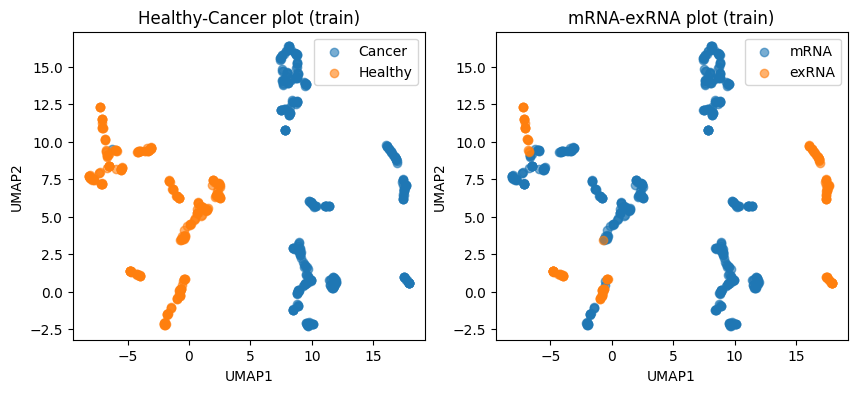

In [18]:
plt.figure(figsize=(10,4))
plt.subplot(121)

iddx = np.where(color_h_c == 0)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='Cancer')

iddx = np.where(color_h_c == 1)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='Healthy')

plt.title('Healthy-Cancer plot (train)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()

plt.subplot(122)
iddx = np.where(color_m_ex == 0)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='mRNA')

iddx = np.where(color_m_ex == 1)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='exRNA')

plt.title('mRNA-exRNA plot (train)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()

In [19]:
##4. Integration visualization - test
net.eval()
with torch.no_grad():
    net.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    y_pred_cm_ts = net.encoder_a(X_all_tensor_cm_ts)
    y_pred_cm_ts = torch.Tensor.cpu(y_pred_cm_ts).detach().numpy()

    y_pred_hm_ts = net.encoder_a(X_all_tensor_hm_ts)
    y_pred_hm_ts = torch.Tensor.cpu(y_pred_hm_ts).detach().numpy()

    y_pred_cex_ts = net.encoder_b(X_all_tensor_cex_ts)
    y_pred_cex_ts = torch.Tensor.cpu(y_pred_cex_ts).detach().numpy()

    y_pred_hex_ts = net.encoder_b(X_all_tensor_hex_ts)
    y_pred_hex_ts = torch.Tensor.cpu(y_pred_hex_ts).detach().numpy()

y_pred_ts = np.concatenate((y_pred_cm_ts, y_pred_hm_ts, y_pred_cex_ts, y_pred_hex_ts),axis=0)

embedding = umaps.transform(y_pred_ts)

In [20]:
color_h_c = np.concatenate(([0]*len(y_pred_cm_ts), [1]*len(y_pred_hm_ts), [0]*len(y_pred_cex_ts), [1]*len(y_pred_hex_ts)))
color_m_ex = np.concatenate(([0]*len(y_pred_cm_ts), [0]*len(y_pred_hm_ts), [1]*len(y_pred_cex_ts), [1]*len(y_pred_hex_ts)))

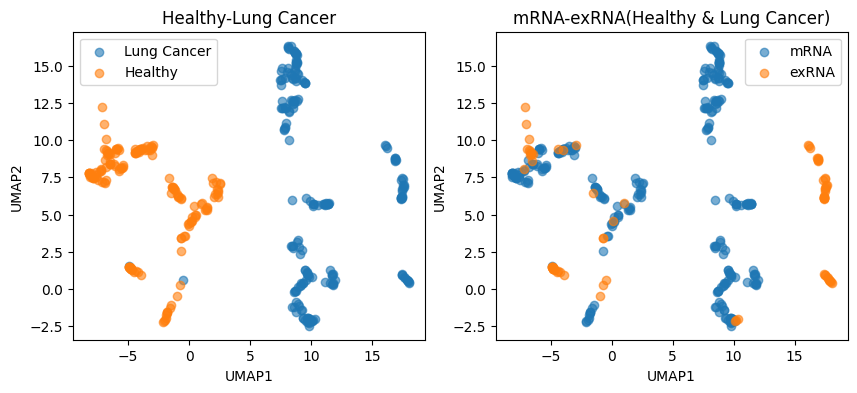

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(121)

iddx = np.where(color_h_c == 0)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='Lung Cancer')

iddx = np.where(color_h_c == 1)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='Healthy')

plt.title('Healthy-Lung Cancer')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()

plt.subplot(122)
iddx = np.where(color_m_ex == 0)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='mRNA')

iddx = np.where(color_m_ex == 1)[0]
plt.scatter(embedding[iddx,0],embedding[iddx,1],alpha=0.6,label='exRNA')

plt.title('mRNA-exRNA(Healthy & Lung Cancer)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()

## KNN

In [22]:
from sklearn.neighbors import NearestNeighbors

knn_m = NearestNeighbors(n_neighbors=10,metric='cosine')
knn_ex = NearestNeighbors(n_neighbors=10,metric='cosine')

knn_m.fit(np.concatenate([y_pred_cm,y_pred_hm]))
knn_ex.fit(np.concatenate([y_pred_cex,y_pred_hex]))

X_knn_m = np.concatenate([X_all_tensor_cm,X_all_tensor_hm])
X_knn_ex = np.concatenate([X_all_tensor_cex,X_all_tensor_hex])

In [23]:
# Cross prediction

eps = 1e-10

def mToEx_multiple(embs):
    dists,idxs = knn_ex.kneighbors(embs)
    dists = dists + eps

    out_ex = np.zeros((len(embs),X_knn_ex.shape[1]))
    for vi in range(len(embs)):
        for i in range(len(dists[vi])):
            out_ex[vi] += (1/dists[vi][i])*X_knn_ex[idxs[vi][i]]
        
        out_ex[vi] = out_ex[vi]/np.sum(1/dists[vi])

    return out_ex

def exToM_multiple(embs):
    dists,idxs = knn_m.kneighbors(embs)
    dists = dists + eps

    out_ex = np.zeros((len(embs),X_knn_m.shape[1]))
    for vi in range(len(embs)):
        for i in range(len(dists[vi])):
            out_ex[vi] += (1/dists[vi][i])*X_knn_m[idxs[vi][i]]
        
        out_ex[vi] = out_ex[vi]/np.sum(1/dists[vi])

    return out_ex

In [24]:
dec_cm = exToM_multiple(y_pred_cex_ts)
dec_hm = exToM_multiple(y_pred_hex_ts)

dec_cex = mToEx_multiple(y_pred_cm_ts)
dec_hex = mToEx_multiple(y_pred_hm_ts)

In [25]:
pred_m = np.concatenate([dec_cm,dec_hm])
true_m = np.concatenate([cancer_mrna_ts,hc_mrna_ts])

pred_ex = np.concatenate([dec_cex,dec_hex])
true_ex = np.concatenate([cancer_exrna_ts,hc_exrna_ts])

### Eval KNN

In [26]:
# Unpaired metric
print("\n\n########## Prediction evaluation ##########\n")

print(stats.pearsonr(np.mean(dec_cm,axis=0),np.mean(cancer_mrna_ts,axis=0)))
print(stats.pearsonr(np.mean(dec_hm,axis=0),np.mean(hc_mrna_ts,axis=0)))
print('Pearson r mRNA (CrossPred):',stats.pearsonr(np.mean(np.concatenate([dec_cm,dec_hm]),axis=0),
                     np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))
print(stats.pearsonr(np.mean(dec_cex,axis=0),np.mean(cancer_exrna_ts,axis=0)))
print(stats.pearsonr(np.mean(dec_hex,axis=0),np.mean(hc_exrna_ts,axis=0)))
print('Pearson r exRNA (CrossPred):',stats.pearsonr(np.mean(np.concatenate([dec_cex,dec_hex]),axis=0),
                     np.mean(np.concatenate([cancer_exrna_ts,hc_exrna_ts]),axis=0)))

#Unpaired Spearman
print(stats.spearmanr(np.mean(dec_cm,axis=0),np.mean(cancer_mrna_ts,axis=0)))
print(stats.spearmanr(np.mean(dec_hm,axis=0),np.mean(hc_mrna_ts,axis=0)))
print('Spearman rank mRNA (CrossPred):',stats.spearmanr(np.mean(np.concatenate([dec_cm,dec_hm]),axis=0),
                     np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))

print(stats.spearmanr(np.mean(dec_cex,axis=0),np.mean(cancer_exrna_ts,axis=0)))
print(stats.spearmanr(np.mean(dec_hex,axis=0),np.mean(hc_exrna_ts,axis=0)))
print('Spearman rank exRNA (CrossPred):',stats.spearmanr(np.mean(np.concatenate([dec_cex,dec_hex]),axis=0),
                     np.mean(np.concatenate([cancer_exrna_ts,hc_exrna_ts]),axis=0)))

print('\n')



########## Prediction evaluation ##########

PearsonRResult(statistic=0.9648238644863361, pvalue=0.0)
PearsonRResult(statistic=0.9588206924502402, pvalue=0.0)
Pearson r mRNA (CrossPred): PearsonRResult(statistic=0.963206855627077, pvalue=0.0)
PearsonRResult(statistic=0.93580589132057, pvalue=0.0)
PearsonRResult(statistic=0.9379669117110935, pvalue=0.0)
Pearson r exRNA (CrossPred): PearsonRResult(statistic=0.946356613691044, pvalue=0.0)
SignificanceResult(statistic=0.9903113532996625, pvalue=0.0)
SignificanceResult(statistic=0.9947665076746808, pvalue=0.0)
Spearman rank mRNA (CrossPred): SignificanceResult(statistic=0.9950199208956052, pvalue=0.0)
SignificanceResult(statistic=0.7960369036940447, pvalue=0.0)
SignificanceResult(statistic=0.6591773071933168, pvalue=2.12292587e-316)
Spearman rank exRNA (CrossPred): SignificanceResult(statistic=0.7297312565258195, pvalue=0.0)




In [27]:
#Unpaired MAE
from sklearn.metrics import mean_absolute_error

print("MAE Cancer mRNA: ",mean_absolute_error(np.mean(dec_cm,axis=0), np.mean(cancer_mrna_ts,axis=0)))
print("MAE Healthy mRNA: ",mean_absolute_error(np.mean(dec_hm,axis=0),np.mean(hc_mrna_ts,axis=0)))
print("MAE mRNA: ",mean_absolute_error(np.mean(np.concatenate([dec_cm,dec_hm]),axis=0),
                                       np.mean(np.concatenate([cancer_mrna_ts,hc_mrna_ts]),axis=0)))
print('\n')
print("MAE Cancer exRNA: ",mean_absolute_error(np.mean(dec_cex,axis=0), np.mean(cancer_exrna_ts,axis=0)))
print("MAE Healthy exRNA: ",mean_absolute_error(np.mean(dec_hex,axis=0),np.mean(hc_exrna_ts,axis=0)))
print("MAE exRNA: ",mean_absolute_error(np.mean(np.concatenate([dec_cex[:,:],dec_hex[:,:]]),axis=0),
                                       np.mean(np.concatenate([cancer_exrna_ts[:,:],hc_exrna_ts[:,:]]),axis=0)))

print("\n\n\n")

MAE Cancer mRNA:  0.3869161395686595
MAE Healthy mRNA:  1.0367549758370416
MAE mRNA:  0.7178628957741207


MAE Cancer exRNA:  2.724420104618922
MAE Healthy exRNA:  17.591129025331487
MAE exRNA:  8.009567517017256






### Top mRNAs

In [28]:
## load data
mrna = pd.read_pickle("./gc_data/gc_mrna_data.pkl")
ex = pd.read_pickle("./gc_data/gc_exnonctg.pkl")

In [29]:
mrna = mrna.set_index('gene_name',drop=True)
mrna.index.name = None
mrna = mrna.drop(columns=['gene_id', 'gene_type','length'])
mrna

,1,2,3,4,5,6,7,8,9,10,...,GTEX-ZVT2-1626-SM-51MRC,GTEX-ZVT3-2126-SM-59HL2,GTEX-ZVZP-1726-SM-5GZWY,GTEX-ZXES-1426-SM-5NQ8S,GTEX-ZY6K-0726-SM-5A5L8,GTEX-ZYFG-1326-SM-5GICJ,GTEX-ZYVF-2726-SM-5GID4,GTEX-ZYY3-1726-SM-5EGH3,GTEX-ZZ64-0426-SM-5E43F,GTEX-ZZPU-1426-SM-5GZZ6
ST6GALNAC6,0.011599,0.042422,0.036856,0.021994,0.001725,0.024492,0.006594,0.012628,0.011023,0.005072,...,2.395933,2.643108,2.702336,2.667727,2.585142,1.578506,6.274365,1.311781,2.650483,3.658588
RPL17,0.607454,0.342046,0.517020,1.831575,0.470261,0.647541,1.334752,0.655582,0.612623,0.880905,...,162.749465,116.453645,116.274136,104.006644,141.091551,115.176051,182.007250,103.632724,153.252965,163.946932
SGSM3,0.014934,0.013176,0.079090,0.016715,0.017587,0.008299,0.026533,0.025164,0.011827,0.051699,...,5.206504,4.940958,5.737718,6.764120,6.907072,6.691505,2.670146,10.305023,5.853975,4.635115
EIF4A1,0.351617,0.284583,0.460241,0.391448,0.386351,0.754897,0.403223,0.509603,0.159481,0.436802,...,48.615001,51.623526,56.111610,43.446992,57.207849,37.423158,106.922829,67.199566,66.850491,55.966762
RPS17,0.819372,0.701002,1.164204,0.915780,0.366656,0.725528,1.505475,0.994668,0.240565,0.815628,...,143.062372,95.203146,102.137291,94.221713,135.609893,105.691288,197.088078,91.573011,134.400839,138.731125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PEX6,0.364460,0.682944,0.352294,0.912265,1.086730,1.021572,0.532924,0.993272,1.409945,1.156495,...,2.343201,1.802804,2.153186,2.634459,2.434918,1.513689,1.838220,1.974815,4.142886,2.422369
PABPC5,0.230789,0.867363,0.209526,0.208388,0.068664,0.117252,0.042176,0.041024,0.538913,0.072085,...,0.058780,0.438015,0.125624,0.194091,0.102773,0.063444,1.094825,0.037040,0.043914,0.364530
CNN1,8.263111,3.467462,0.726872,2.269135,17.973717,18.830660,1.565254,0.870649,431.212049,7.385668,...,5.396421,20.192950,7.019029,7.550032,6.721674,3.717160,72.913946,7.558693,6.027409,52.586994
SLC33A1,0.688441,0.580762,0.607978,0.375075,0.294804,0.470895,0.375220,0.541713,0.275471,0.318502,...,1.148753,1.121973,1.137000,0.779335,1.596958,1.013457,1.123434,0.713068,1.008930,0.996870


/tmp/ipykernel_2185250/1190452096.py:15: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


Text(0.5, 0, 'mRNA value')

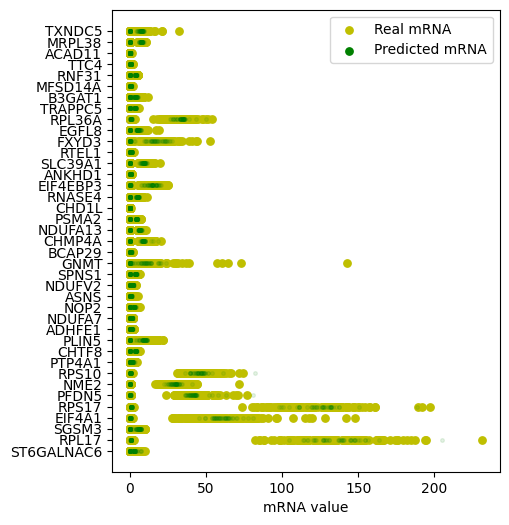

In [30]:
fig = plt.figure(figsize =(5, 6))
gn=39

for i in range(len(mrna.index[:gn])):
#     plt.scatter(pred_m[:,i],y=np.ones(pred_m.shape[0])*(i+1))
#     plt.hlines(y = i+1, xmin=min(true_m[:,i]), xmax=max(true_m[:,i]), color = 'g', linestyle = '-') 
    if i == 0:
        plt.scatter(true_m[:,i],y=np.ones(true_m.shape[0])*(i+1),c='y',s=28,label='Real mRNA')
        plt.scatter(pred_m[:,i],y=np.ones(pred_m.shape[0])*(i+1),alpha=0.1,c='g',s=7, label='Predicted mRNA')
    else:
        plt.scatter(true_m[:,i],y=np.ones(true_m.shape[0])*(i+1),c='y',s=28)
        plt.scatter(pred_m[:,i],y=np.ones(pred_m.shape[0])*(i+1),alpha=0.1,c='g',s=7)
leg = plt.legend()

for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([28])

plt.yticks(np.arange(1,gn+1),mrna.index[:gn])
plt.xlabel('mRNA value')

### Top exRNAs

/tmp/ipykernel_2185250/343962076.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


Text(0.5, 0, 'exRNA value')

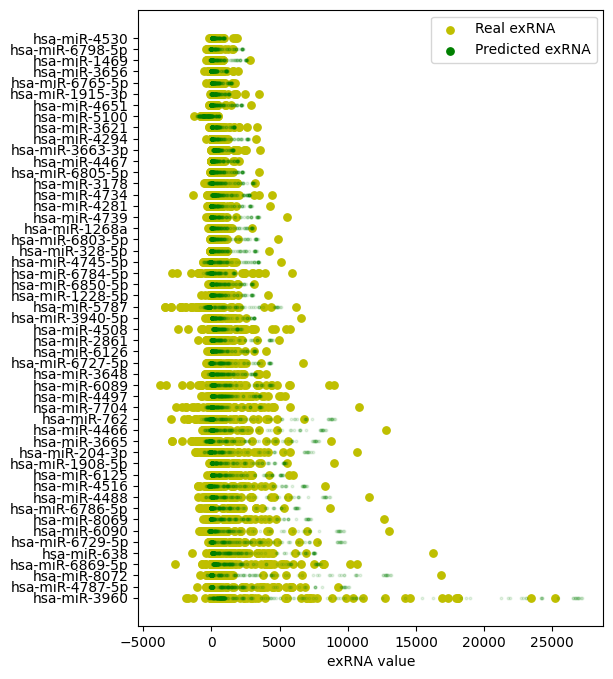

In [31]:
fig = plt.figure(figsize =(6, 8))
gn_ex=51

for i in range(len(ex.index[:gn_ex])):
    if i == 0:
        plt.scatter(true_ex[:,i],y=np.ones(true_ex.shape[0])*(i+1),c='y',s=28, label='Real exRNA')
        plt.scatter(pred_ex[:,i],y=np.ones(pred_ex.shape[0])*(i+1),alpha=0.1,c='g',s=3.5, label = 'Predicted exRNA')
#     plt.hlines(y = i+1, xmin=min(true_ex[:,i]), xmax=max(true_ex[:,i]), color = 'g', linestyle = '-') 
    else:
        plt.scatter(true_ex[:,i],y=np.ones(true_ex.shape[0])*(i+1),c='y',s=28)
        plt.scatter(pred_ex[:,i],y=np.ones(pred_ex.shape[0])*(i+1),alpha=0.1,c='g',s=3.5)

leg = plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([28])
plt.yticks(np.arange(1,gn_ex+1),ex.index[:gn_ex])
plt.xlabel('exRNA value')

### Important exRNA identification

In [32]:
mrna_std=[]
exrna_std = []
for i in range(cancer_mrna_tr.shape[1]):
    mrna_std.append(np.std(np.concatenate([cancer_mrna_tr[:,i],hc_mrna_tr[:,i]])))
for i in range(cancer_exrna_tr.shape[1]):
    exrna_std.append(np.std(np.concatenate([cancer_exrna_tr[:,i],hc_exrna_tr[:,i]])))
    
print(len(mrna_std))
print(len(exrna_std))

1653
2539


In [34]:
print('\n\n########## Calculating important exRNAs. ########## \nThis would take around 4.5Hrs to complete on a standard machine. You can see the progress status below:')
net.eval()
net.to(torch.device("cpu"))

n=50
dist = np.zeros([n,cancer_exrna_ts.shape[1]])

true_val = np.concatenate([dec_cm,dec_hm])

with torch.no_grad():
    for j in tqdm.tqdm(range(n)):
        for i in range(cancer_exrna_ts.shape[1]):

            X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
            X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

            c_ex_noise = np.random.normal(0,exrna_std[i],cancer_exrna_ts.shape[0])
            h_ex_noise = np.random.normal(0,exrna_std[i],hc_exrna_ts.shape[0])

            X_all_tensor_cex_ts[:,i] = X_all_tensor_cex_ts[:,i]+torch.tensor(c_ex_noise*0.01).float()
            X_all_tensor_hex_ts[:,i] = X_all_tensor_hex_ts[:,i]+torch.tensor(h_ex_noise*0.01).float()

            y_pred_cex_ts = net.encoder_b(X_all_tensor_cex_ts)
            y_pred_cex_ts = torch.Tensor.cpu(y_pred_cex_ts).detach().numpy()

            y_pred_hex_ts = net.encoder_b(X_all_tensor_hex_ts)
            y_pred_hex_ts = torch.Tensor.cpu(y_pred_hex_ts).detach().numpy()

            tensor_ex_all = np.concatenate([y_pred_cex_ts,y_pred_hex_ts])
            pred_m_all = exToM_multiple(tensor_ex_all)

            d = np.linalg.norm(pred_m_all - true_val)        

            dist[j,i] = d
            



########## Calculating important exRNAs. ########## 
This would take around 4.5Hrs to complete on a standard machine. You can see the progress status below:


  0%|                                                                                  | 0/50 [00:01<?, ?it/s]


In [35]:
dist_avg = []
for i in range(dist.shape[1]):
    dist_avg.append(np.mean(dist[:,i]))

[  0 852 851 850 849 848 847 846 845 844 853 842 841 840 839 838 837 836
 835 843 872 871 870 869 868 867 866 865 864 854 862 861 860 859 858 857
 856 855 834 863 813 812 811 810 809 808 807 806 805 833 803]


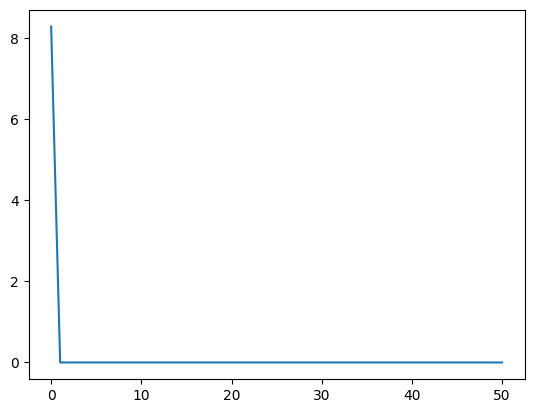

In [36]:
gn_m = 51
plt.plot(dist_avg[:gn_m])
print(np.flip(np.argsort(dist_avg))[:gn_m])
# print(dist)
# print(ex.index[13])

In [37]:
dist_m = np.flip(np.sort(dist_avg))[:gn_m]
print(dist_m[:gn_m])


[8.28507021 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [38]:
ind = np.flip(np.argsort(dist_avg))[:gn_m]
print(ex.index[ind])

Index(['hsa-miR-3960', 'hsa-let-7c-3p', 'hsa-miR-6737-3p', 'hsa-miR-3191-5p',
       'hsa-miR-5095', 'hsa-miR-598-5p', 'hsa-miR-196a-3p', 'hsa-miR-26b-3p',
       'hsa-miR-7974', 'hsa-miR-4748', 'hsa-miR-1321', 'hsa-miR-181a-2-3p',
       'hsa-miR-631', 'hsa-miR-4795-5p', 'hsa-miR-4701-5p', 'hsa-miR-1250-3p',
       'hsa-miR-3940-3p', 'hsa-miR-4524b-5p', 'hsa-miR-4733-3p',
       'hsa-miR-5009-5p', 'hsa-miR-3181', 'hsa-miR-3913-3p', 'hsa-miR-4285',
       'hsa-miR-4788', 'hsa-miR-6855-3p', 'hsa-miR-3186-3p', 'hsa-miR-4664-5p',
       'hsa-miR-1286', 'hsa-miR-5708', 'hsa-miR-4654', 'hsa-miR-148a-5p',
       'hsa-miR-219a-1-3p', 'hsa-miR-3137', 'hsa-miR-3925-3p',
       'hsa-miR-6723-5p', 'hsa-miR-3159', 'hsa-miR-548g-3p', 'hsa-miR-4423-5p',
       'hsa-miR-4529-3p', 'hsa-miR-6890-5p', 'hsa-miR-3136-5p',
       'hsa-miR-6740-3p', 'hsa-miR-499a-5p', 'hsa-miR-6735-5p',
       'hsa-miR-625-3p', 'hsa-miR-517c-3p', 'hsa-miR-424-3p',
       'hsa-miR-7151-3p', 'hsa-miR-103b', 'hsa-miR-181c-3p',

### Important mRNA identification

In [40]:
print('\n\n########## Calculating important mRNAs. ########## \nThis would take around 4.5Hrs to complete on a standard machine. You can see the progress status below:')
net.eval()
net.to(torch.device("cpu"))

n=50
dist_m = np.zeros([n,cancer_mrna_ts.shape[1]])

true_val_ex = np.concatenate([dec_cex,dec_hex])

with torch.no_grad():
    for j in tqdm.tqdm(range(n)):
        for i in range(cancer_mrna_ts.shape[1]):

            X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
            X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

            c_m_noise = np.random.normal(0,mrna_std[i],cancer_mrna_ts.shape[0])
            h_m_noise = np.random.normal(0,mrna_std[i],hc_mrna_ts.shape[0])

            X_all_tensor_cm_ts[:,i] = X_all_tensor_cm_ts[:,i]+torch.tensor(c_m_noise*0.01).float()
            X_all_tensor_hm_ts[:,i] = X_all_tensor_hm_ts[:,i]+torch.tensor(h_m_noise*0.01).float()

            y_pred_cm_ts = net.encoder_a(X_all_tensor_cm_ts)
            y_pred_cm_ts = torch.Tensor.cpu(y_pred_cm_ts).detach().numpy()

            y_pred_hm_ts = net.encoder_a(X_all_tensor_hm_ts)
            y_pred_hm_ts = torch.Tensor.cpu(y_pred_hm_ts).detach().numpy()

            tensor_m_all = np.concatenate([y_pred_cm_ts,y_pred_hm_ts])
            pred_ex_all = mToEx_multiple(tensor_m_all)

            d = np.linalg.norm(pred_ex_all - true_val_ex)        

            dist_m[j,i] = d
            



########## Calculating important mRNAs. ########## 
This would take around 4.5Hrs to complete on a standard machine. You can see the progress status below:


  0%|                                                                                  | 0/50 [00:01<?, ?it/s]


In [41]:
dist_avg_ex = []
for i in range(dist_m.shape[1]):
    dist_avg_ex.append(np.mean(dist_m[:,i]))
    

[  0 543 544 545 546 547 548 549 550 551 552 553 542 555 556 557 558 559
 560 561 562 563 564 565 566 554 517 518 519 520 521 522 523 524 525 526
 527 528 541]


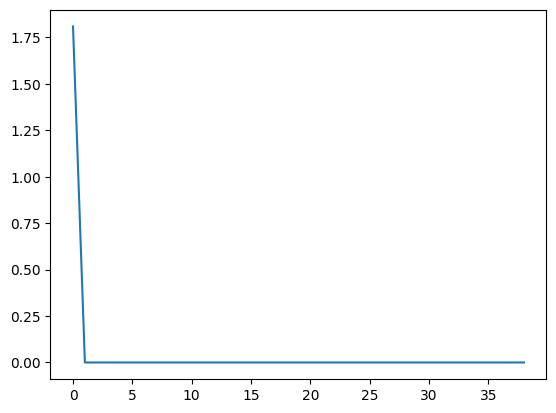

In [42]:
gn_m = 39
plt.plot(dist_avg_ex[:gn_m])
print(np.flip(np.argsort(dist_avg_ex))[:gn_m])

In [43]:
ind_ex = np.flip(np.argsort(dist_avg_ex))[:gn_m]
print(mrna.index[ind_ex])

Index(['ST6GALNAC6', 'HAUS7', 'ADAMTS8', 'HSPB8', 'RAB43', 'ZNF345',
       'SELENBP1', 'COL4A3', 'LRRN4CL', 'CHST3', 'TOGARAM2', 'ABCF2', 'TCEAL3',
       'PTP4A3', 'SORBS1', 'TRIM45', 'KCNJ15', 'YPEL4', 'PEBP4', 'VAMP1',
       'ERRFI1', 'IFFO1', 'CIART', 'XKR4', 'CSAD', 'ZNF700', 'CACNA2D3',
       'CEP85L', 'AKR1C2', 'RIMS3', 'PNISR', 'NPTX2', 'RASGRP2', 'BCL2L2',
       'PDE1C', 'PHYHIP', 'MRPS28', 'DYNLRB1', 'DMPK'],
      dtype='object')


### Negative Loglikeluhood mRNA

In [44]:
from typing import Callable
def negative_binom_loss(
    scale_factor: float = 1.0,
    eps: float = 1e-10,
    mean: bool = True,
    debug: bool = False,
#     tb: torch.utils.tensorboard.SummaryWriter = None,
) -> Callable:
    """
    Return a function that calculates the binomial loss
    https://github.com/theislab/dca/blob/master/dca/loss.py

    combination of the Poisson distribution and a gamma distribution is a negative binomial distribution
    """

    def loss(preds, theta, truth, tb_step: int = None):
        """Calculates negative binomial loss as defined in the NB class in link above"""
        y_true = truth
        y_pred = preds * scale_factor
        
        global th_lg
        global ytr_lg
        global ytr_th_lg

        if debug:  # Sanity check before loss calculation
            assert not torch.isnan(y_pred).any(), y_pred
            assert not torch.isinf(y_pred).any(), y_pred
            assert not (y_pred <= 0).any()  # should be non-negative
            assert not (theta <= 0).any()

        # Clip theta values
        theta = torch.clamp(theta, max=1e6)

        t1 = (
            torch.lgamma(theta + eps)
            + torch.lgamma(y_true + 1.0)
            - torch.lgamma(y_true + theta + eps)
        )
        
        th_lg = torch.lgamma(theta + eps).clone()
        ytr_lg = torch.lgamma(y_true + 1.0).clone()
        ytr_th_lg = torch.lgamma(y_true + theta + eps).clone()
        
        
#         print(torch.lgamma(theta + eps),torch.lgamma(y_true + 1.0), torch.lgamma(y_true + theta + eps))
        
        t2 = (theta + y_true) * torch.log1p(y_pred / (theta + eps)) + (
            y_true * (torch.log(theta + eps) - torch.log(y_pred + eps))
        )
        if debug:  # Sanity check after calculating loss
            assert not torch.isnan(t1).any(), t1
            assert not torch.isinf(t1).any(), (t1, torch.sum(torch.isinf(t1)))
            assert not torch.isnan(t2).any(), t2
            assert not torch.isinf(t2).any(), t2

        retval = (t1 + t2)
        if debug:
            assert not torch.isnan(retval).any(), retval
            assert not torch.isinf(retval).any(), retval

#         if tb is not None and tb_step is not None:
#             tb.add_histogram("nb/t1", t1, global_step=tb_step)
#             tb.add_histogram("nb/t2", t2, global_step=tb_step)

        return torch.mean(retval) if mean else retval
    return loss

In [45]:
gn_m=39
X_real_m = torch.concatenate((X_all_tensor_cm_ts[:,:gn_m], X_all_tensor_hm_ts[:,:gn_m]),axis=0)
loss_real = []

for i in range(X_real_m.shape[1]):
    m = torch.mean(X_real_m[:,i])
    v = torch.var(X_real_m[:,i])

    nll = negative_binom_loss()

    loss_real.append(nll(m, v, X_real_m[:,i]))


In [46]:
tensor_pred_cm = torch.tensor(dec_cm).float()
tensor_pred_hm = torch.tensor(dec_hm).float()

X_pred_m = torch.concatenate((tensor_pred_cm[:,:gn_m], tensor_pred_hm[:,:gn_m]),axis=0)
loss_pred = []

for i in range(X_pred_m.shape[1]):
    m = torch.mean(X_pred_m[:,i])
    v = torch.var(X_pred_m[:,i])

    nll = negative_binom_loss()

    loss_pred.append(nll(m, v, X_pred_m[:,i]))


In [47]:
tensor_pred_cm_b = torch.tensor(b_pred_cm_ts[:,:gn_m]).float()
tensor_pred_hm_b = torch.tensor(b_pred_hm_ts[:,:gn_m]).float()

b_pred_m = torch.concatenate((tensor_pred_cm_b,tensor_pred_hm_b),axis=0)
loss_pred_b = []

for i in range(b_pred_m.shape[1]):
    m = torch.mean(b_pred_m[:,i])
    v = torch.var(b_pred_m[:,i])

    nll = negative_binom_loss()

    loss_pred_b.append(nll(m, v, b_pred_m[:,i]))


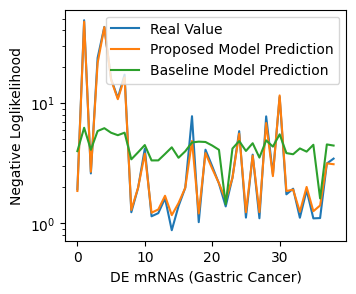

In [48]:
fig = plt.figure(figsize =(8, 3))

plt.subplot(121)
plt.semilogy(loss_real[:gn_m], label='Real Value')
plt.semilogy(loss_pred[:gn_m], label='Proposed Model Prediction')
plt.semilogy(loss_pred_b[:gn_m], label='Baseline Model Prediction')
plt.xlabel("DE mRNAs (Gastric Cancer)")
plt.ylabel("Negative Loglikelihood")
plt.legend()


### Negative loglikelihood exRNA graph

In [49]:
gn_ex=51
tensor_pred_cex = torch.tensor(dec_cex).float()
tensor_pred_hex = torch.tensor(dec_hex).float()

X_pred_ex = torch.concatenate((tensor_pred_cex[:,:gn_ex], tensor_pred_hex[:,:gn_ex]),axis=0)

X_real_ex = torch.concatenate((X_all_tensor_cex_ts[:,:gn_ex], X_all_tensor_hex_ts[:,:gn_ex]),axis=0)

b_pred_ex = torch.concatenate((torch.tensor(b_pred_cex_ts[:,:gn_ex]).float(),torch.tensor(b_pred_hex_ts[:,:gn_ex]).float()),
                              axis=0)

m_real = []
s_real = []
m_pred = []
s_pred = []
m_pred_b = []
s_pred_b = []


for i in range(X_real_ex.shape[1]):
    m = torch.mean(X_real_ex[:,i])
    s = torch.std(X_real_ex[:,i])
    
    m_p = torch.mean(X_pred_ex[:,i])
    s_p = torch.std(X_pred_ex[:,i])
    
    m_p_b = torch.mean(b_pred_ex[:,i])
    s_p_b = torch.std(b_pred_ex[:,i])

#     nll = negative_binom_loss()

    m_real.append(m)
    s_real.append(s)
    m_pred.append(m_p)
    s_pred.append(s_p)
    m_pred_b.append(m_p_b)
    s_pred_b.append(s_p_b)


In [50]:
loss = torch.nn.GaussianNLLLoss()
true_loss_ex = []
pred_loss_ex = []
b_pred_loss_ex = []

for i in range(X_real_ex.shape[1]):
    r_real_ex = np.random.normal(m_real[i], s_real[i], X_real_ex.shape[0])
    r_pred_ex = np.random.normal(m_pred[i], s_pred[i], X_pred_ex.shape[0])
    r_pred_ex_b = np.random.normal(m_pred_b[i], s_pred_b[i], b_pred_ex.shape[0])
    
    true_loss_ex.append(loss(X_real_ex[:,i], r_real_ex,s_real[i]**2)) 
#     print(true_loss_ex)
    pred_loss_ex.append(loss(X_pred_ex[:,i], r_pred_ex,s_pred[i]**2))
#     print(pred_loss_ex)
    b_pred_loss_ex.append(loss(b_pred_ex[:,i], r_pred_ex_b,s_pred_b[i]**2))

Text(0, 0.5, 'Negative Loglikelihood')

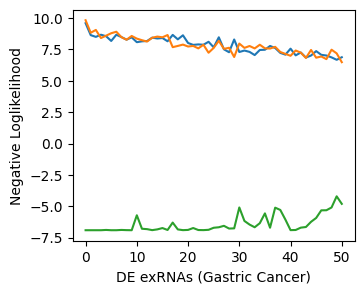

In [51]:
fig = plt.figure(figsize =(8, 3))
gn_ex = 51
plt.subplot(121)
plt.plot(true_loss_ex[:gn_ex], label='Real Value')
plt.plot(pred_loss_ex[:gn_ex], label='Proposed Model Prediction')
plt.plot(b_pred_loss_ex[:gn_ex], label='Baseline Model Prediction')
plt.xlabel("DE exRNAs (Gastric Cancer)")
plt.ylabel("Negative Loglikelihood")
# plt.legend()

## Test result for encoders with both exRNA

In [52]:
class CrossPred_exex(torch.nn.Module):
    def __init__(self,input_dim_a=2000,input_dim_b=2000,emb_dim=128):
        super(CrossPred_exex, self).__init__()
        self.input_dim_a = input_dim_a
        self.input_dim_b = input_dim_b
        self.encoder_a = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_a, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        self.encoder_b = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_b, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        
    def forward(self, x_a,x_b):
        out_a = self.encoder_a(x_a)        
        out_b = self.encoder_b(x_b)
        return out_a,out_b


In [53]:
checkpoint_exex = torch.load('./models/gc_model_exex.pt',map_location=torch.device('cpu'))
net_exex = CrossPred_exex(input_dim_a=cancer_exrna_ts.shape[1],input_dim_b=cancer_exrna_ts.shape[1])
net_exex.load_state_dict(checkpoint_exex['model_state_dict'])
net_exex.eval()

CrossPred_exex(
  (encoder_a): Sequential(
    (0): Linear(in_features=2539, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_b): Sequential(
    (0): Linear(in_features=2539, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [54]:
## Integration visualization - test-bothexrna
net_exex.eval()
with torch.no_grad():
    net_exex.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    y_pred_cex2_ts = net_exex.encoder_a(X_all_tensor_cex_ts)
    y_pred_cex2_ts = torch.Tensor.cpu(y_pred_cex2_ts).detach().numpy()

    y_pred_hex2_ts = net_exex.encoder_a(X_all_tensor_hex_ts)
    y_pred_hex2_ts = torch.Tensor.cpu(y_pred_hex2_ts).detach().numpy()

    y_pred_cex1_ts = net_exex.encoder_b(X_all_tensor_cex_ts)
    y_pred_cex1_ts = torch.Tensor.cpu(y_pred_cex1_ts).detach().numpy()

    y_pred_hex1_ts = net_exex.encoder_b(X_all_tensor_hex_ts)
    y_pred_hex1_ts = torch.Tensor.cpu(y_pred_hex1_ts).detach().numpy()

y_pred_exex_ts = np.concatenate((y_pred_cex2_ts, y_pred_hex2_ts, y_pred_cex1_ts, y_pred_hex1_ts),axis=0)

# embedding_exex_ts = umaps_exex.transform(y_pred_exex_ts)

## Test result for encoders with both mRNA

In [55]:
class CrossPred_mm(torch.nn.Module):
    def __init__(self,input_dim_a=2000,input_dim_b=2000,emb_dim=128):
        super(CrossPred_mm, self).__init__()
        self.input_dim_a = input_dim_a
        self.input_dim_b = input_dim_b
#         self.clf_out = clf_out
        self.encoder_a = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_a, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        self.encoder_b = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim_b, 1000),
            torch.nn.BatchNorm1d(1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, emb_dim))
        
    def forward(self, x_a,x_b):
        out_a = self.encoder_a(x_a)
        
        out_b = self.encoder_b(x_b)
        return out_a,out_b

In [56]:
checkpoint_mm = torch.load('./models/gc_model_mm.pt',map_location=torch.device('cpu'))
net_mm = CrossPred_mm(input_dim_a=cancer_mrna_ts.shape[1],input_dim_b=cancer_mrna_ts.shape[1])
net_mm.load_state_dict(checkpoint_mm['model_state_dict'])
net_mm.eval()

CrossPred_mm(
  (encoder_a): Sequential(
    (0): Linear(in_features=1653, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_b): Sequential(
    (0): Linear(in_features=1653, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [57]:
##4. Integration visualization - test-bothmrna
net_mm.eval()
with torch.no_grad():
    net_mm.to(torch.device("cpu"))

    X_all_tensor_cm_ts = torch.tensor(cancer_mrna_ts).float()
    X_all_tensor_hm_ts = torch.tensor(hc_mrna_ts).float()

    X_all_tensor_cex_ts = torch.tensor(cancer_exrna_ts).float()
    X_all_tensor_hex_ts = torch.tensor(hc_exrna_ts).float()

    y_pred_cm2_ts = net_mm.encoder_a(X_all_tensor_cm_ts)
    y_pred_cm2_ts = torch.Tensor.cpu(y_pred_cm2_ts).detach().numpy()

    y_pred_hm2_ts = net_mm.encoder_a(X_all_tensor_hm_ts)
    y_pred_hm2_ts = torch.Tensor.cpu(y_pred_hm2_ts).detach().numpy()

    y_pred_cm1_ts = net_mm.encoder_b(X_all_tensor_cm_ts)
    y_pred_cm1_ts = torch.Tensor.cpu(y_pred_cm1_ts).detach().numpy()

    y_pred_hm1_ts = net_mm.encoder_b(X_all_tensor_hm_ts)
    y_pred_hm1_ts = torch.Tensor.cpu(y_pred_hm1_ts).detach().numpy()

y_pred_mm_ts = np.concatenate((y_pred_cm2_ts, y_pred_hm2_ts, y_pred_cm1_ts, y_pred_hm1_ts),axis=0)

# embedding_mm_ts = umaps_mm.transform(y_pred_mm_ts)

## Pairwise distance between cancer and healthy samples with different embedding space 

In [58]:
y_pred_all = [[y_pred_cm2_ts,y_pred_cm1_ts,y_pred_hm2_ts,y_pred_hm1_ts],[y_pred_cex2_ts,y_pred_cex1_ts,y_pred_hex2_ts,y_pred_hex1_ts],[y_pred_cm_ts,y_pred_cex_ts,y_pred_hm_ts,y_pred_hex_ts]]#,[umap_mm,umap_xx,umap_mx]]
s = 'y_pred_all_lc = [[y_pred_cm2_ts,y_pred_cm1_ts,y_pred_hm2_ts,y_pred_hm1_ts],[y_pred_cex2_ts,y_pred_cex1_ts,y_pred_hex2_ts,y_pred_hex1_ts],[y_pred_cm_ts,y_pred_cex_ts,y_pred_hm_ts,y_pred_hex_ts]]'

# umap_fits = [y_pred_mm,y_pred_exex,y_pred]
# sumap = 'umap_fits_lc = [y_pred_mm,y_pred_exex,y_pred]'

with open('y_pred_all_gc_test.pkl','wb') as f:
    pickle.dump([y_pred_all,s],f)
    
# with open('y_pred_all_lc_umapfit.pkl','wb') as f:
#     pickle.dump([umap_fits,sumap],f)

In [61]:
with open('./y_pred_all_gc_test.pkl','rb') as f:
    datalist = pickle.load(f)

# with open('./y_pred_all_lc_umapfit.pkl','rb') as f:
#     umapdata = pickle.load(f)

dataType = 'Gastric cancer'

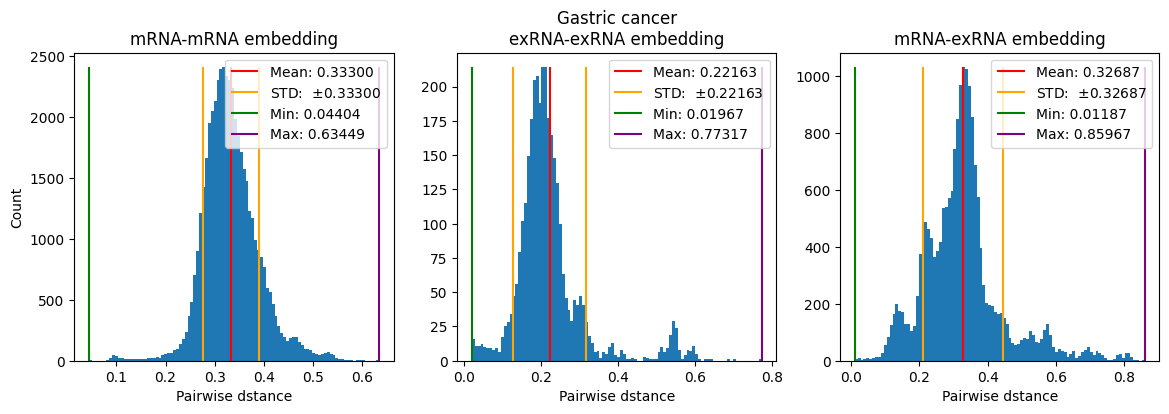

In [62]:
plt.figure(figsize=(14,4))

plt.subplot(131)
dist_mx = cdist(np.concatenate([datalist[0][0][0],datalist[0][0][1]]),np.concatenate([datalist[0][0][2],datalist[0][0][3]]))
dist_mx_v = dist_mx[np.tril_indices_from(dist_mx,k=-1)]

hg,_,_ = plt.hist(dist_mx_v,bins=100)
plt.xlabel('Pairwise dstance')
mvv = np.mean(dist_mx_v)
plt.vlines(mvv,0,np.max(hg),'r',label='Mean: {:.5f}'.format(np.mean(mvv)))
plt.vlines([mvv - np.std(dist_mx_v),mvv + np.std(dist_mx_v)],0,np.max(hg),'orange',label='STD: '+r' $\pm$'+'{:.5f}'.format(np.mean(dist_mx_v)))
plt.vlines(np.min(dist_mx_v),0,np.max(hg),'g',label='Min: {:.5f}'.format(np.min(dist_mx_v)))
plt.vlines(np.max(dist_mx_v),0,np.max(hg),'purple',label='Max: {:.5f}'.format(np.max(dist_mx_v)))

plt.title('mRNA-mRNA embedding')
plt.ylabel('Count')

plt.legend()


plt.subplot(132)
dist_mx = cdist(np.concatenate([datalist[0][1][0],datalist[0][1][1]]),np.concatenate([datalist[0][1][2],datalist[0][1][3]]))
dist_mx_v = dist_mx[np.tril_indices_from(dist_mx,k=-1)]

hg,_,_ = plt.hist(dist_mx_v,bins=100)
plt.xlabel('Pairwise dstance')
mvv = np.mean(dist_mx_v)
plt.vlines(mvv,0,np.max(hg),'r',label='Mean: {:.5f}'.format(np.mean(mvv)))
plt.vlines([mvv - np.std(dist_mx_v),mvv + np.std(dist_mx_v)],0,np.max(hg),'orange',label='STD: '+r' $\pm$'+'{:.5f}'.format(np.mean(dist_mx_v)))
plt.vlines(np.min(dist_mx_v),0,np.max(hg),'g',label='Min: {:.5f}'.format(np.min(dist_mx_v)))
plt.vlines(np.max(dist_mx_v),0,np.max(hg),'purple',label='Max: {:.5f}'.format(np.max(dist_mx_v)))

plt.title('{}\nexRNA-exRNA embedding'.format(dataType))
# plt.ylabel('Count')

plt.legend()


plt.subplot(133)
dist_mx = cdist(np.concatenate([datalist[0][2][0],datalist[0][2][1]]),np.concatenate([datalist[0][2][2],datalist[0][2][3]]))
dist_mx_v = dist_mx[np.tril_indices_from(dist_mx,k=-1)]

hg,_,_ = plt.hist(dist_mx_v,bins=100)
plt.xlabel('Pairwise dstance')
mvv = np.mean(dist_mx_v)
plt.vlines(mvv,0,np.max(hg),'r',label='Mean: {:.5f}'.format(np.mean(mvv)))
plt.vlines([mvv - np.std(dist_mx_v),mvv + np.std(dist_mx_v)],0,np.max(hg),'orange',label='STD: '+r' $\pm$'+'{:.5f}'.format(np.mean(dist_mx_v)))
plt.vlines(np.min(dist_mx_v),0,np.max(hg),'g',label='Min: {:.5f}'.format(np.min(dist_mx_v)))
plt.vlines(np.max(dist_mx_v),0,np.max(hg),'purple',label='Max: {:.5f}'.format(np.max(dist_mx_v)))

plt.title('mRNA-exRNA embedding')
# plt.ylabel('Count')

plt.legend()